# Analysis of PageRank Algorithm on PPI network
I created a PPI network using the interactions from ConsensusPathDB and I joined it with gene expression data (dual RNA-seq) obtained for the legionella infection setting.

In the dual RNA-seq, we have the following groups:
* *Control* (not treated)
* *GFP+* (cells with legionella infection)
* *GFP-* (cells without legionella)
* *PAM3* (inflammatory substance treatment. Should produce results similar to GFP+)

The gene expression for ~40.000 genes was preprocessing in the following way:
* Kick out genes whose average gene expression was higher than $10 \times$ the standard deviation
* Kick out genes with only less than 50% of the gene expressions being different from 0
* Scaled using a standard scaler

The network was then constructed for those genes only. That is, an edge is drawn between two genes only if both of them are in the list of genes for which we have gene expression and if the confidence of the interactions exceed $0.5$.

After network construction, isolated genes (no edges for gene) got kicked out as well. I am afterwards left with a network of 4862 genes.

On this network I applied the well-known PageRank algorithm. This resulted in a score for each gene and a higher score means that the gene is more important in the network.

**The goal of this notebook is to evaluate the results from PageRank, look into correlations with gene expression/differential expression, pathways and finally visualize the important genes in the network.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

## Load PageRank scores & Indices
This loads the gene expression data as well as the raw network from our hdf5 container.

In [2]:
# load gene expression values and network
fname = '../data/preprocessing/ppi_networks.h5'
with h5py.File(fname, 'r') as f:
    gene_expression_data = pd.DataFrame(f['gene_expression'][:])
    ppi_network = f['consensusPathDB_ppi'][:]
    gene_names = f['gene_names'][:]

# load pagerank scores and ranks
pagerank_scores = pd.DataFrame.from_csv('../data/pagerank/pagerank_scores.txt',
                                        encoding='utf-8',
                                        sep='\t',
                                        index_col=0
                                       )

In [142]:
print (pagerank_scores.shape, ppi_network.shape)

(10367, 3) (10367, 10367)


## Correlations between PageRank & Gene Expression Variance
Let's check the correlations between the PageRank and the variance of the gene expression. Trivially, one would expect that the high variance genes would be more prominent in the network.

However, there are a couple of factors that introduce noise here:
* The variance is calculated over 3 replicates of GFP+, GFP-, Control and PAM3. A couple of these groups are not expected to change during the time course of the infection so looking at the variance doesn't nessessarily make sense.
* There is experimental bias in here as well. Sometimes the replicates have very high variance, even though the gene is not at all differentially expressed.

In [4]:
# get the IDs from file and set them as index axis for the expression
expr_with_names = gene_expression_data.set_index(gene_names[:, 0]) #they have the same ordering

# set gene expression variance, mean and median and add to dataframe
expr_var = pd.DataFrame(expr_with_names.var(axis=1))
expr_var.columns = ['Gene_Expression_Variance']
expr_mean = pd.DataFrame(expr_with_names.mean(axis=1))
expr_mean.columns = ['Gene_Expression_Mean']
expr_median = pd.DataFrame(expr_with_names.median(axis=1))
expr_median.columns = ['Gene_Expression_Median']
pagerank_with_ge = pagerank_scores.join([expr_var, expr_mean, expr_median])

# write that to file
pagerank_with_ge.to_csv('../pagerank/pagerank_scores_with_ge.txt', sep='\t')

In [5]:
# compute correlation between gene expression and pagerank
#sorted_gene_expression = pagerank_with_ge.sort_values(by='Gene_Expression_Median', ascending=False)
print ("Correlation between PageRank & GE Mean: {}". \
       format(pagerank_with_ge.Gene_Expression_Mean.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE Variance: {}". \
       format(pagerank_with_ge.Gene_Expression_Variance.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE Median: {}". \
       format(pagerank_with_ge.Gene_Expression_Median.corr(pagerank_with_ge.PageRank_Score)))

Correlation between PageRank & GE Mean: 0.25249851342965485
Correlation between PageRank & GE Variance: 0.13464956179773263
Correlation between PageRank & GE Median: 0.26318118241544763


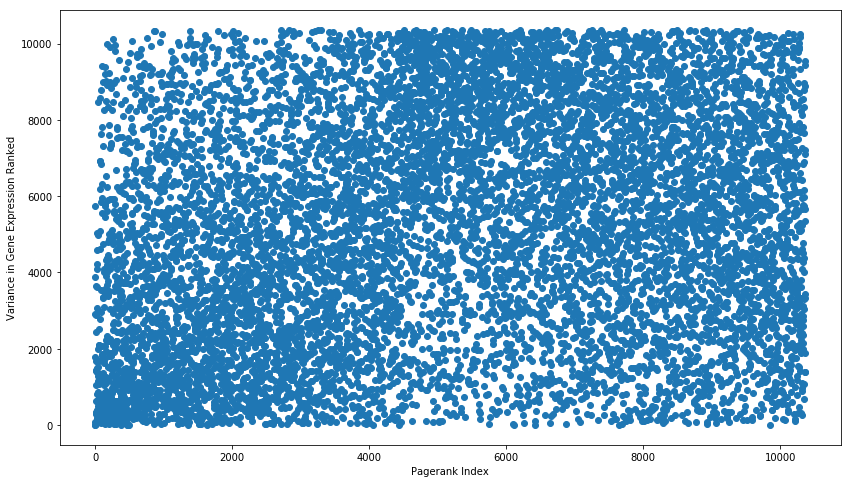

In [31]:
fig = plt.figure(figsize=(14, 8))
ranked_ge_var = np.argsort(pagerank_with_ge.Gene_Expression_Variance)[::-1]
ax = plt.scatter(pagerank_with_ge.Rank, ranked_ge_var)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Variance in Gene Expression Ranked')

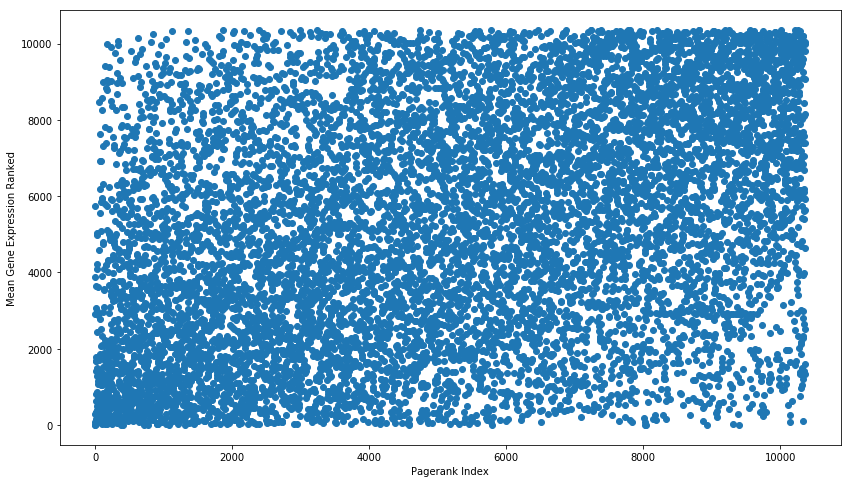

In [33]:
fig = plt.figure(figsize=(14, 8))
ranked_ge_mean = np.argsort(pagerank_with_ge.Gene_Expression_Mean)[::-1]
ax = plt.scatter(pagerank_with_ge.Rank, ranked_ge_mean)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Mean Gene Expression Ranked')

## Correlations between PageRank & Differential Expression
Because of the flaws of using only the variance, let's try having a look at the differentially expressed genes.
This should overcome the issues and maybe reveal some correlation between PageRank and DE.

Unfortunately, we only have GE data for the differentially expressed genes, while for all others, the p-values are $<0.05$

In [34]:
# load DE for GFP+ after 8 hours. Unfortunately, we only get DE for pval < .05
differential_expression = pd.DataFrame.from_csv('../data/differential_expression/GFPplusT8vsControlT805.tsv',
                                                sep='\t',
                                                index_col=2
                                               )
# remove gene name (already there)
differential_expression.drop('Gene-name', axis=1, inplace=True)
differential_expression.shape

(1016, 7)

In [35]:
pagerank_ge_and_de = pagerank_with_ge.join(differential_expression)

# compute correlation between differential expression and pagerank
print ("Correlation between PageRank & DE pvalue: {}". \
       format(pagerank_ge_and_de.pvalue.corr(pagerank_ge_and_de.PageRank_Score)))
print ("Correlation between PageRank & DE log2FoldChange: {}". \
       format(pagerank_ge_and_de.log2FoldChange.corr(pagerank_with_ge.PageRank_Score)))
print ("Correlation between PageRank & GE baseMean: {}". \
       format(pagerank_ge_and_de.baseMean.corr(pagerank_with_ge.PageRank_Score)))

Correlation between PageRank & DE pvalue: -0.013440189897036334
Correlation between PageRank & DE log2FoldChange: 0.0556053481999321
Correlation between PageRank & GE baseMean: 0.14060747339316298


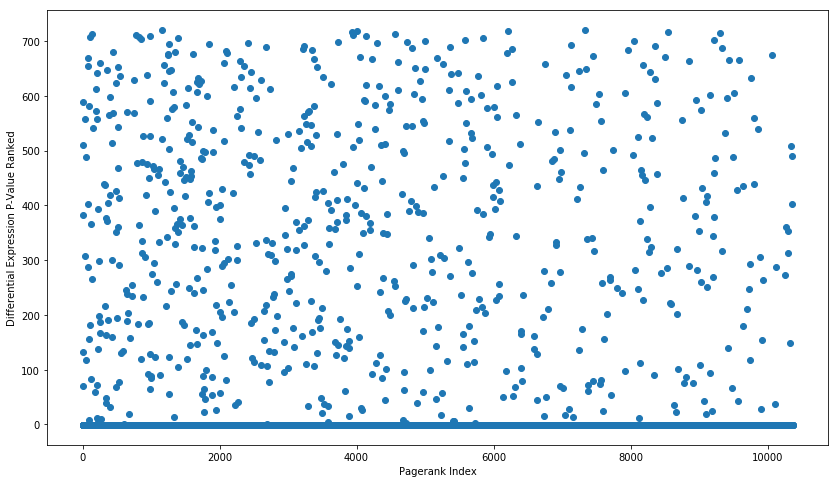

In [42]:
fig = plt.figure(figsize=(14, 8))
ranked_de = np.argsort(pagerank_ge_and_de.pvalue)
ax = plt.scatter(pagerank_ge_and_de.Rank, ranked_de)
#plt.xlim([0, 0.004])
t = plt.xlabel('Pagerank Index')
t = plt.ylabel('Differential Expression P-Value Ranked')

## Correlations between PageRank & Gene Expression PCA Loadings
When the variance/mean of the gene expression doesn't correlate with the PageRank, let's try something different.
I want to see if there is a correlation between the PCA loadings from the 20% most varying  genes and the PageRank.

In [43]:
loadings_pc1 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_1.tsv',
                                     sep='\t'
                                    )
loadings_pc1 = loadings_pc1.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc2 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_2.tsv',
                                     sep='\t'
                                    )
loadings_pc2 = loadings_pc2.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

loadings_pc3 = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_3.tsv',
                                     sep='\t'
                                    )
loadings_pc3 = loadings_pc3.drop(['Abs_Loadings', 'Gene_Name'], axis=1)

In [44]:
pagerank_de_ge_loadings = pagerank_ge_and_de
for comp in range(1, 4):
    loadings = pd.DataFrame.from_csv('../data/preprocessing/loadings_comp_{}.tsv'.format(comp),
                                         sep='\t'
                                        )
    loadings.drop('Abs_Loadings', axis=1, inplace=True)
    loadings.drop('Gene_Name', axis=1, inplace=True) # gene name is already there
    loadings.columns = ['Loadings_Comp{}'.format(comp)]
    pagerank_de_ge_loadings = pagerank_de_ge_loadings.join(loadings, how='left')
    print (pagerank_de_ge_loadings.shape)
pagerank_de_ge_loadings.head()

(10367, 14)
(10367, 15)
(10367, 16)


,Gene_Name,Rank,PageRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3
Gene_ID,,,,,,,,,,,,,,,,
ENSG00000142192,APP,1,0.003701,0.137244,0.344002,0.215163,protein_coding,323.270761,1.620050,0.534173,3.032819,0.002423,0.129019,0.005021,0.001109,-0.000214
ENSG00000198400,NTRK1,2,0.003564,0.000842,-0.105612,-0.114468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000082898,XPO1,3,0.002591,0.094383,0.634362,0.731523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.004233,-0.004978,-0.001615
ENSG00000150991,UBC,4,0.002264,1005.958932,37.256122,22.989679,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.533175,-0.256197,0.005203
ENSG00000036257,CUL3,5,0.002251,0.011816,0.193717,0.209924,protein_coding,168.843146,-0.522971,0.208860,-2.503933,0.012282,0.184508,-0.000761,-0.002393,0.000476


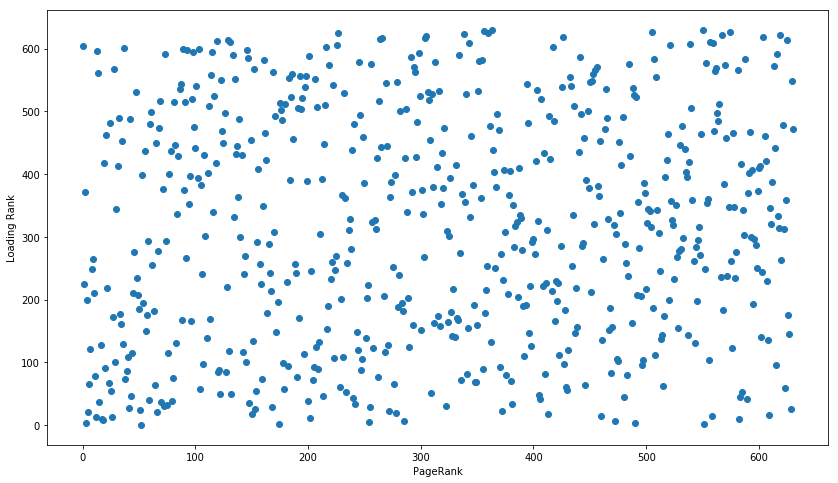

In [88]:
fig = plt.figure(figsize=(14, 8))
pc1_df = loadings_pc1.join(pagerank_ge_and_de)
pc1_df.dropna(axis=0, inplace=True)
ranked_loadings_pc1 = np.argsort(pc1_df.Loadings)[::-1]
plt.scatter(np.argsort(pc1_df.Rank), ranked_loadings_pc1)
plt.xlabel('PageRank')
plt.ylabel('Loading Rank')

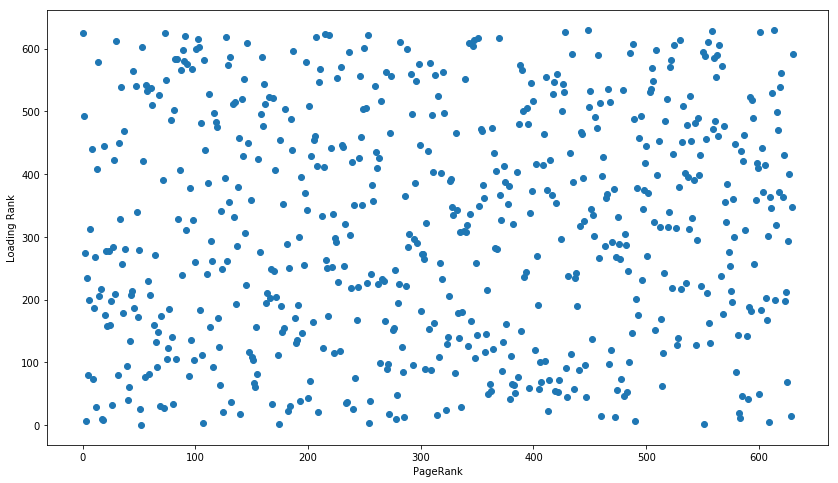

In [97]:
fig = plt.figure(figsize=(14, 8))
pc2_df = loadings_pc2.join(pagerank_ge_and_de)
pc2_df.dropna(axis=0, inplace=True)
ranked_loadings_pc2 = np.argsort(pc2_df.Loadings)[::-1]
plt.scatter(np.argsort(pc2_df.Rank), ranked_loadings_pc2)
plt.xlabel('PageRank')
plt.ylabel('Loading Rank')

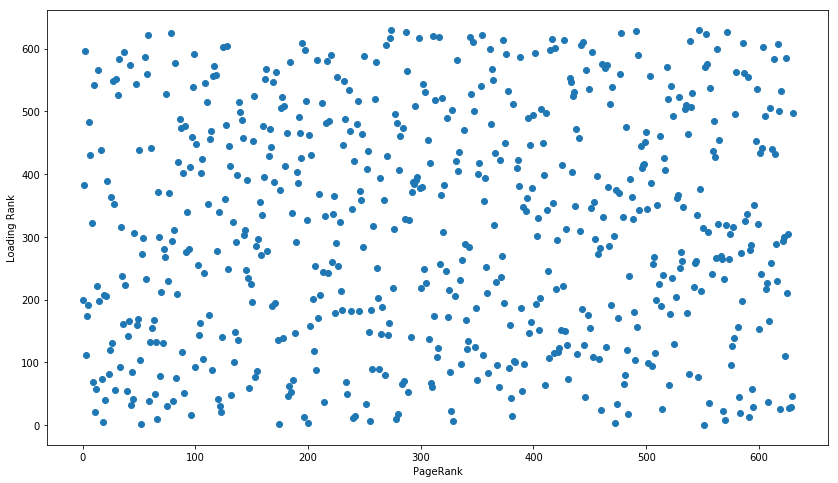

In [94]:
fig = plt.figure(figsize=(14, 8))
pc3_df = loadings_pc3.join(pagerank_ge_and_de)
pc3_df.dropna(axis=0, inplace=True)
ranked_loadings_pc3 = np.argsort(pc3_df.Loadings)
plt.scatter(np.argsort(pc3_df.Rank), ranked_loadings_pc3)
plt.xlabel('PageRank')
plt.ylabel('Loading Rank')

## Correlations of PageRank and Network Properties
Next, I'd like to do a sanity check. The PageRank should somehow correlate with basic network properties, such as:
* Node Degree
* Betweenness
* etc.

In [98]:
import networkx as nx

In [99]:
G = nx.from_numpy_matrix(A=ppi_network)
node_degree = nx.degree(G)
degree_np = np.zeros(len(node_degree))
if float(nx.__version__) >= 2:
    for key, val in node_degree:
        degree_np[key] = val
else:
    for key, val in node_degree.items():
        degree_np[key] = val

In [100]:
print ("Mean Node Degree in PPI Network: {}".format(degree_np.mean()))

Mean Node Degree in PPI Network: 30.201794154528795


[9695 1136 5455 ..., 5781 8704 4346]


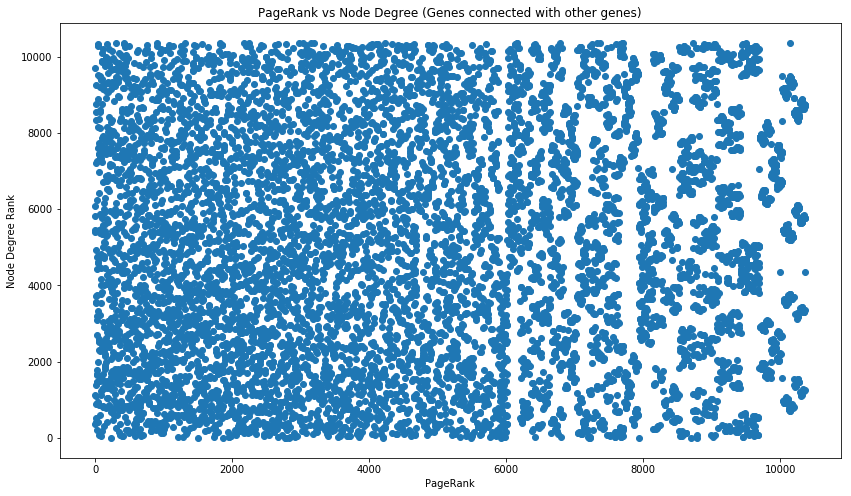

In [116]:
fig = plt.figure(figsize=(14, 8))
degree_rank = np.argsort(degree_np)[::-1]
plt.scatter(pagerank_ge_and_de.Rank, degree_rank)
plt.title('PageRank vs Node Degree (Genes connected with other genes)')
plt.xlabel('PageRank')
plt.ylabel('Node Degree Rank')

In [137]:
# centrality now (takes time)
betweenness_centrality = nx.betweenness_centrality(G)

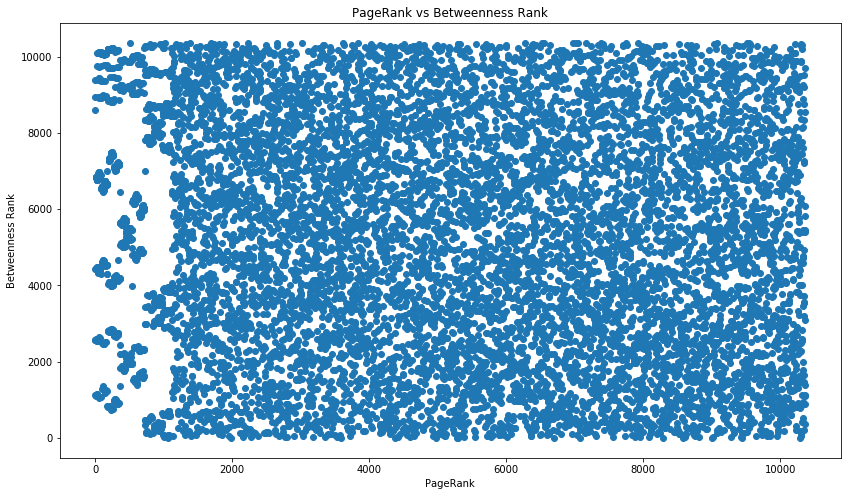

In [143]:
betweenness_np = np.zeros(len(node_degree))
for key, val in betweenness_centrality.items():
    betweenness_np[key] = val

fig = plt.figure(figsize=(14, 8))
betweenness_rank = np.argsort(betweenness_np)
plt.scatter(pagerank_ge_and_de.Rank, betweenness_rank)
plt.title('PageRank vs Betweenness Rank')
plt.xlabel('PageRank')
plt.ylabel('Betweenness Rank')

### Fuse Dataframe with gene expression, differential expression, loadings and network properties

In [144]:
network_props = pd.DataFrame(np.vstack([degree_np, betweenness_np]).T)
network_props.columns = ['Node_Degree', 'Node_Betweenness']
network_props = network_props.set_index(gene_names[:, 0])
pagerank_whole_props = pagerank_de_ge_loadings.join(network_props)

In [145]:
# compute correlation between gene expression and pagerank
print ("Correlation between PageRank & Node Degree: {}". \
       format(pagerank_whole_props.Node_Degree.corr(pagerank_whole_props.PageRank_Score)))
print ("Correlation between PageRank & Node Betweenness: {}". \
       format(pagerank_whole_props.Node_Betweenness.corr(pagerank_whole_props.PageRank_Score)))

Correlation between PageRank & Node Degree: 0.9798937761928643
Correlation between PageRank & Node Betweenness: 0.8268395023161496


## Write Whole Dataframe to Disk

In [146]:
pagerank_whole_props.to_csv('../data/pagerank/network_properties.tsv', sep='\t')

## Do Wigos genes pop up in my top candidates?
I found some high correlation between network properties, differential expression and gene expression with the results from PageRank.

Next, I want to know if any of the high ranked genes also pop up in the list that I got from Wigo.

In [149]:
infection_genes = pd.DataFrame.from_csv('../data/labels/labels_wigo_codingonly.csv', sep='\t', index_col=3)
my_infection_genes = pd.DataFrame.from_csv('../data/labels/my_labels_literaturesearch.tsv',
                                           sep='\t',
                                           index_col=1
                                          )
infection_genes = infection_genes.append(my_infection_genes)

In [148]:
count = 0
for index, row in infection_genes.iterrows():
    if index in pagerank_scores.index:
        print ('Found Ensembl ID {} ({})\tPageRank: {}'\
               .format(index, row['Gene-name'], pagerank_scores.loc[index]['Rank'])
              )
        count += 1
print ("-------------------------------------------")
print ("Total items found in Wigos List and the network: {}".format(count))
print ("Total number of infection genes (labels): {}".format(infection_genes.shape[0]))

Found Ensembl ID ENSG00000144381 (HSPD1)	PageRank: 182
Found Ensembl ID ENSG00000149257 (SERPINH1)	PageRank: 1512
Found Ensembl ID ENSG00000086061 (DNAJA1)	PageRank: 1269
Found Ensembl ID ENSG00000105993 (DNAJB6)	PageRank: 2267
Found Ensembl ID ENSG00000170606 (HSPA4)	PageRank: 139
Found Ensembl ID ENSG00000087074 (PPP1R15A)	PageRank: 3328
Found Ensembl ID ENSG00000013441 (CLK1)	PageRank: 1095
Found Ensembl ID ENSG00000168439 (STIP1)	PageRank: 529
Found Ensembl ID ENSG00000114416 (FXR1)	PageRank: 1210
Found Ensembl ID ENSG00000004478 (FKBP4)	PageRank: 1229
Found Ensembl ID ENSG00000184205 (TSPYL2)	PageRank: 1901
Found Ensembl ID ENSG00000092531 (SNAP23)	PageRank: 1668
Found Ensembl ID ENSG00000099860 (GADD45B)	PageRank: 5603
Found Ensembl ID ENSG00000160570 (DEDD2)	PageRank: 7128
Found Ensembl ID ENSG00000008294 (SPAG9)	PageRank: 3377
Found Ensembl ID ENSG00000108510 (MED13)	PageRank: 2675
Found Ensembl ID ENSG00000143514 (TP53BP2)	PageRank: 983
Found Ensembl ID ENSG00000135517 (Mip)	P

## Add label column to network properties
For visualization in cytoscape, it will be helpful if the labeled genes are marked somehow. Here, I add a label column to the already calculated network properties to have a look at their distribution in the network.

In [203]:
# load dataframe and add label column
pagerank_whole_props = pd.DataFrame.from_csv('../data/pagerank/network_properties.tsv', sep='\t')
pagerank_whole_props['is_label'] = False

# only select infection genes present in the data
infection_genes_present = infection_genes[infection_genes.index.isin(pagerank_whole_props.index)]
pagerank_whole_props.ix[infection_genes_present.index, 'is_label'] = True

# write back to disk
pagerank_whole_props.to_csv('../data/pagerank/network_properties.tsv', sep='\t')

# print information on the labels
print ("Number of Labels in Dataset: {}".format(pagerank_whole_props.is_label.sum()))
pagerank_whole_props[pagerank_whole_props.is_label]

Number of Labels in Dataset: 27


,Gene_Name,Rank,PageRank_Score,Gene_Expression_Variance,Gene_Expression_Mean,Gene_Expression_Median,Gene-type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Loadings_Comp1,Loadings_Comp2,Loadings_Comp3,Node_Degree,Node_Betweenness,is_label
Gene_ID,,,,,,,,,,,,,,,,,,,
ENSG00000177885,GRB2,8,0.001916,0.102209,0.594980,0.607916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001742,-0.006932,0.001507,683.0,2.085331e-02,True
ENSG00000170606,HSPA4,139,0.000575,0.146227,0.704949,0.616638,protein_coding,950.125382,1.042980,0.520345,2.004402,0.045027,0.277328,0.005452,-0.002899,-0.000740,228.0,2.225545e-03,True
ENSG00000109320,NFKB1,164,0.000541,0.186789,0.567220,0.527026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002058,0.000994,-0.009355,212.0,1.943422e-03,True
ENSG00000144381,HSPD1,182,0.000524,8.413739,3.200060,1.920078,protein_coding,2543.659981,1.577442,0.591305,2.667731,0.007637,0.159851,0.049837,0.003602,-0.005279,192.0,3.532699e-03,True
ENSG00000120738,EGR1,273,0.000430,0.001212,-0.100780,-0.107107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,1.537022e-03,True
ENSG00000168439,STIP1,529,0.000300,0.186304,0.396950,0.255074,protein_coding,366.833694,1.716553,0.559308,3.069064,0.002147,0.129019,0.006283,0.001089,-0.001674,117.0,5.282605e-04,True
ENSG00000143761,ARF1,658,0.000268,0.085308,0.741410,0.810968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002055,-0.006134,-0.001705,86.0,5.826453e-04,True
ENSG00000138069,RAB1A,825,0.000240,0.002925,0.130008,0.130463,protein_coding,152.883822,0.853714,0.295762,2.886491,0.003896,0.138594,0.000024,-0.000494,-0.000340,84.0,3.609635e-04,True
ENSG00000143514,TP53BP2,983,0.000213,0.018720,0.277128,0.273960,protein_coding,277.856552,1.031855,0.426190,2.421117,0.015473,0.196146,0.001498,-0.001108,-0.001328,83.0,2.479781e-04,True
